# Imports

In [2]:
import pickle
import random
import numpy as np
import pandas as pd
from scipy import signal

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, Dropout, Flatten, Concatenate, Input, BatchNormalization, LSTM, Add, Reshape

In [3]:
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Loading Data

In [4]:
udf = pd.read_json("dataset/unified.json")
udf.index.name = "number"

In [5]:
udf.head(n = 10)

,sid,gender,age,height,weight,sbp,dbp,hr,bmi,signal
number,,,,,,,,,,
0,2,0,45,152,63,161,89,97,27.268006,"[2438.0, 2438.0, 2438.0, 2455.0, 2455.0, 2384...."
1,3,0,50,157,50,160,93,76,20.284799,"[1965.0, 1965.0, 1960.0, 1960.0, 1960.0, 1959...."
2,6,0,47,150,47,101,71,79,20.888889,"[1942.0, 1912.0, 1912.0, 1912.0, 1905.0, 1905...."
3,8,1,45,172,65,136,93,87,21.971336,"[2039.0, 2039.0, 2039.0, 2029.0, 2029.0, 2042...."
4,9,0,46,155,65,123,73,73,27.055151,"[1939.0, 1939.0, 1959.0, 1959.0, 1980.0, 1980...."
5,10,0,48,160,68,124,62,70,26.562500,"[2078.0, 2078.0, 2078.0, 2038.0, 2038.0, 2046...."
6,11,0,48,153,49,126,78,84,20.932120,"[1955.0, 1958.0, 1958.0, 1958.0, 1927.0, 1927...."
7,12,0,53,160,70,108,73,84,27.343750,"[1915.0, 1879.0, 1879.0, 1879.0, 1887.0, 1887...."
8,13,1,58,165,55,89,42,63,20.202020,"[1958.0, 1958.0, 1983.0, 1983.0, 1942.0, 1942...."


In [6]:
fdf = udf[["gender", "age", "height", "weight", "bmi", "hr", "signal", "sbp", "dbp"]]

In [7]:
fdf.head(n = 10)

,gender,age,height,weight,bmi,hr,signal,sbp,dbp
number,,,,,,,,,
0,0,45,152,63,27.268006,97,"[2438.0, 2438.0, 2438.0, 2455.0, 2455.0, 2384....",161,89
1,0,50,157,50,20.284799,76,"[1965.0, 1965.0, 1960.0, 1960.0, 1960.0, 1959....",160,93
2,0,47,150,47,20.888889,79,"[1942.0, 1912.0, 1912.0, 1912.0, 1905.0, 1905....",101,71
3,1,45,172,65,21.971336,87,"[2039.0, 2039.0, 2039.0, 2029.0, 2029.0, 2042....",136,93
4,0,46,155,65,27.055151,73,"[1939.0, 1939.0, 1959.0, 1959.0, 1980.0, 1980....",123,73
5,0,48,160,68,26.562500,70,"[2078.0, 2078.0, 2078.0, 2038.0, 2038.0, 2046....",124,62
6,0,48,153,49,20.932120,84,"[1955.0, 1958.0, 1958.0, 1958.0, 1927.0, 1927....",126,78
7,0,53,160,70,27.343750,84,"[1915.0, 1879.0, 1879.0, 1879.0, 1887.0, 1887....",108,73
8,1,58,165,55,20.202020,63,"[1958.0, 1958.0, 1983.0, 1983.0, 1942.0, 1942....",89,42


In [8]:
def extract_signals (sig):
    # Z-score Normalized Signal

    sig = (np.array(sig) - np.mean(sig)) / np.std(sig)
    
    # Signal Filteration
    
    b, a = signal.butter(6, 0.02)
    sig = signal.filtfilt(b, a, sig, padlen = 150)
    
    # Baseline Correction
    
    def correct_baseline (signal):
        x = np.arange(signal.shape[0])
        model = np.poly1d(np.polyfit(x, signal, 4))
        curve = model(x)
        return signal - curve
    
    # sig = correct_baseline(sig)

    return sig

In [9]:
fdf.loc[:, "signal"] = fdf.loc[:, "signal"].apply(extract_signals)

In [10]:
fdf.head(n = 5)

,gender,age,height,weight,bmi,hr,signal,sbp,dbp
number,,,,,,,,,
0,0,45,152,63,27.268006,97,"[1.590562567557697, 1.5775034402293273, 1.5644...",161,89
1,0,50,157,50,20.284799,76,"[-0.9001521149549024, -0.9087394946232823, -0....",160,93
2,0,47,150,47,20.888889,79,"[-0.7938204461538355, -0.7987723327231911, -0....",101,71
3,1,45,172,65,21.971336,87,"[0.057303482399721946, 0.049066062454962235, 0...",136,93
4,0,46,155,65,27.055151,73,"[-1.5311177944378238, -1.516337610608393, -1.5...",123,73


In [11]:
feature_matrix = fdf.to_numpy()

with open("dataset/dl_features.pickle", "wb") as handler:
    pickle.dump(feature_matrix, handler)

In [13]:
with open("dataset/dl_features.pickle", "rb") as handler:
  data = pickle.load(handler)

# Preparing Data

In [14]:
data

array([[0, 45, 152, ...,
        array([ 1.59056257,  1.57750344,  1.56442879, ..., -1.09200229,
               -1.10237785, -1.11278381])                              ,
        161, 89],
       [0, 50, 157, ...,
        array([-0.90015211, -0.90873949, -0.91734821, ..., -0.01484337,
               -0.02161649, -0.02844602])                              ,
        160, 93],
       [0, 47, 150, ...,
        array([-0.79382045, -0.79877233, -0.80371757, ...,  1.52694795,
                1.52490825,  1.52294986])                              ,
        101, 71],
       ...,
       [1, 25, 176, ...,
        array([ 2.59759573,  2.57996914,  2.56232806, ..., -0.86719182,
               -0.86927038, -0.87135184])                              ,
        120, 69],
       [1, 25, 173, ...,
        array([ 0.36625151,  0.35833802,  0.3504161 , ..., -0.94636353,
               -0.94573363, -0.94510002])                              ,
        106, 69],
       [1, 24, 175, ...,
        array([ 1.92853

In [15]:
x = data[:, :-3]
sigs = data[:, -3]
y = data[:, -2]

In [16]:
from scipy import signal

In [17]:
S = []
for i in range(sigs.shape[0]):
    ydem = signal.decimate(sigs[i][:2100], 20)
    S.append(ydem)
S = np.asarray(S)
S.shape

(219, 105)

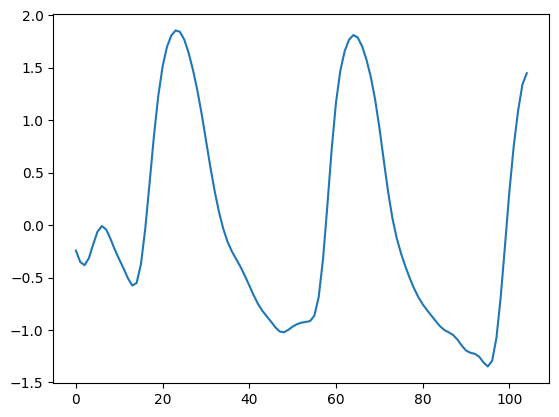

In [18]:
plt.plot(S[43, :])

In [19]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [20]:
scaler = MinMaxScaler()
scaler.fit(S)
S = scaler.transform(S)

In [21]:
y = np.asarray(y, dtype = np.float32)

In [22]:
x_train, x_test, S_train, S_test, y_train, y_test = train_test_split(
    x, S, y,
    test_size = 0.2,
    shuffle = True,
    random_state = 1
)

# Model Definition

https://github.com/HealthSciTech/Robust_PPG_PD/blob/master/PPG_peak_detection.py
https://www.mdpi.com/2075-4418/13/15/2566

In [23]:
def cnn_model():

    # model = Sequential()

    # #------------------------------------
    # # Conv Block 1: 32 Filters, MaxPool.
    # #------------------------------------
    # model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    # model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))

    # #------------------------------------
    # # Conv Block 2: 64 Filters, MaxPool.
    # #------------------------------------
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))

    # #------------------------------------
    # # Conv Block 3: 64 Filters, MaxPool.
    # #------------------------------------
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))

    # #------------------------------------
    # # Flatten the convolutional features.
    # #------------------------------------
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dense(1, activation='relu'))

    # return model

    in1 = Input(shape = (105, 1))
    in2 = Input(shape = (6, 1))

    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", padding='same')(in1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=5, filters=16, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=7, filters=16, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=9, filters=64, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=9, filters=64, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    
    # x1 = Conv1D(kernel_size=3, filters=32, activation="elu", dilation_rate=2, padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=2)(x1)
    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=4, padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=2)(x1)
    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=8, padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=2)(x1)

    ####
    # x1 = Conv1D(filters=32, kernel_size=2, activation="relu", padding='same')(in1)
    # x1 = AveragePooling1D(pool_size=4, strides=4)(x1)
    # x1 = Conv1D(filters=64, kernel_size=4, activation="relu", padding='same')(x1)
    # x1 = AveragePooling1D(pool_size=4, strides=2)(x1)
    # x1 = Conv1D(filters=32, kernel_size=6, activation="relu", padding='same')(x1)
    # x1 = AveragePooling1D(pool_size=4, strides=2)(x1)
    ####


    ##3
    x1 = Conv1D(filters=8, kernel_size=2, activation="relu", padding='same')(in1)
    x1 = Conv1D(filters=16, kernel_size=4, activation="relu", padding='same')(x1)
    x1 = MaxPooling1D(pool_size=3, strides=3)(x1)
    x1 = Conv1D(filters=32, kernel_size=6, activation="relu", padding='same')(x1)
    x1 = Conv1D(filters=32, kernel_size=8, strides=2, activation="relu", padding='same')(x1)
    x1 = Conv1D(filters=64, kernel_size=10, strides=2, activation="relu", padding='same')(x1)
    x1 = MaxPooling1D(pool_size=4, strides=4)(x1)
    ###
    
    
    # x1 = Conv1D(kernel_size=3, filters=4, activation="elu", dilation_rate=1, padding='same')(in1)
    # x1 = Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=2, padding='same')(x1)
    # x1 = Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=4, padding='same')(x1)
    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=8, padding='same')(x1)
    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=16, padding='same')(x1)
    # x1 = Conv1D(kernel_size=3, filters=32, activation="elu", dilation_rate=32, padding='same')(x1)
    # x1 = Conv1D(kernel_size=3, filters=1, activation="elu", dilation_rate=64, padding='same')(x1)
    
    x1 = Flatten()(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = tf.expand_dims(x1, axis = 2)
    # x1 = LSTM(32)(x1)
    # x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.1)(x1)
    x1 = Dense(64, activation='relu')(x1)
    x1 = Dense(32, activation='relu')(x1)
    # x1 = Dense(16, activation='relu')(x1)
    # x1 = Dense(1, activation='relu')(x1)
    # x3 = x1
    
    x2 = Flatten()(in2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Dense(64, activation='relu')(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Dense(32, activation='relu')(x2)
    # x2 = Dense(1, activation='relu')(x2)
    x3 = Concatenate()([x1, x2])
    # x3 = Dropout(0.1)(x3)
    x3 = Dense(32, activation='relu')(x3)
    x3 = Dense(1, activation='relu')(x3)

    # model = Model(inputs = [in1, in2], outputs = x3)
    model = Model(inputs = [in1, in2], outputs = x3)

    # model = Sequential(
    #     [
    #         Conv1D(kernel_size=3, filters=4, activation="elu", dilation_rate=1, padding='same', input_shape=input_shape),
    #         Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=2, padding='same'),
    #         Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=4, padding='same'),
    #         Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=8, padding='same'),
    #         Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=16, padding='same'),
    #         Conv1D(kernel_size=3, filters=32, activation="elu", dilation_rate=32, padding='same'),
    #         Conv1D(kernel_size=3, filters=1, activation="elu", dilation_rate=64, padding='same'),
    #         Flatten(),
    #         Concatenate(),
    #         Dense(1, activation='elu')
    #     ]
    # )

    return model

In [24]:
model = cnn_model()
model.summary()

I0000 00:00:1724557772.730947   95729 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-25 07:19:32.731480: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 105, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 105, 8)    │         24 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 105, 16)   │        528 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 35, 16)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 35, 32)    │      3,104 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 18, 32)    │      8,224 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 9, 64)     │     20,544 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2, 64)     │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6)         │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │        896 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 72,617 (283.66 KB)

 Trainable params: 72,617 (283.66 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
%load_ext tensorboard
logdir = "logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
model.compile(optimizer='adam',  loss='mae',  metrics=['mae'])

In [30]:
EPOCHS = 250
# S_train = np.swapaxes(S_train, 1, 2)
# S_train = np.expand_dims(S_train, axis = 2)
# x_train = np.expand_dims(x_train, axis = 2)
history = model.fit([S_train, x_train],
                    y_train,
                    batch_size=50,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split=0.25,
                    callbacks=[tensorboard_callback]
                   )

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 129.4050 - mae: 129.4050 - val_loss: 119.6727 - val_mae: 119.6727
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 129.3086 - mae: 129.3086 - val_loss: 119.4977 - val_mae: 119.4977
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 129.0972 - mae: 129.0972 - val_loss: 119.1869 - val_mae: 119.1869
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 128.7259 - mae: 128.7259 - val_loss: 118.5613 - val_mae: 118.5613
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 127.9615 - mae: 127.9615 - val_loss: 117.1120 - val_mae: 117.1120
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 126.1960 - mae: 126.1960 - val_loss: 113.6002 - val_mae: 113.6002
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 121.9476 - mae: 121.9476 - val_loss: 105.0861 - val_mae: 105.0861
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 111.7835 - mae: 111.7835 - val_loss: 84.9857 - val_mae: 84.9857
Epoch 9/2

In [20]:
# %tensorboard --logdir logs/

In [31]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics]
        metric_name = [metric_name]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])
        
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

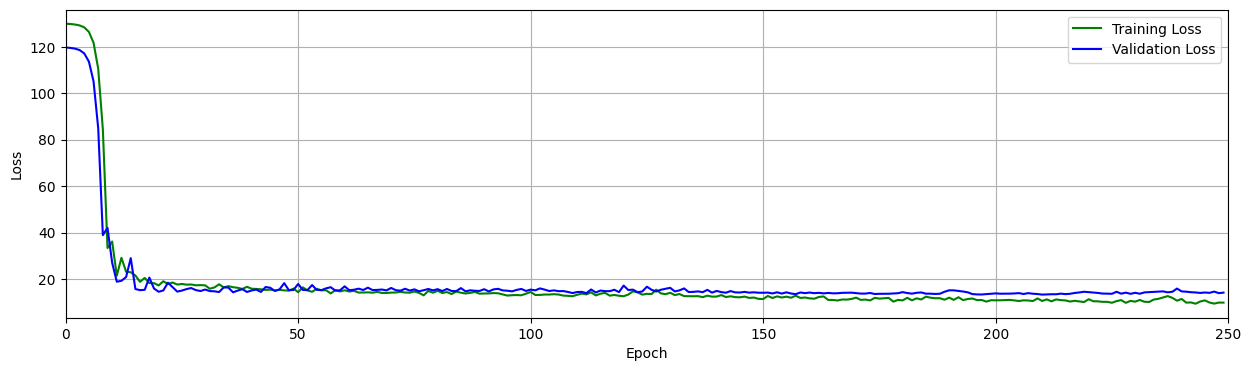

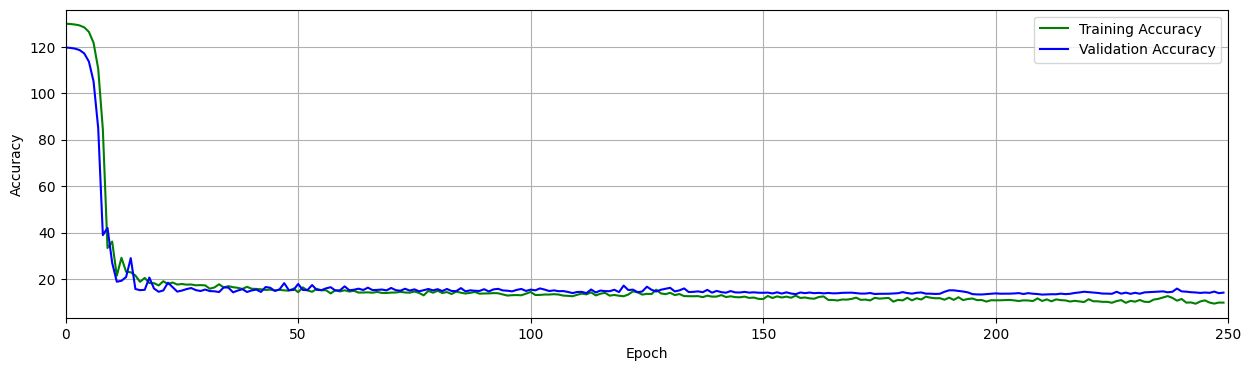

In [32]:
train_loss = history.history["loss"]
train_acc  = history.history["mae"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_mae"]

plot_results([train_loss, valid_loss],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([train_acc, valid_acc],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [33]:
# S_test = np.swapaxes(S_test, 1, 2)
test_loss, test_acc = model.evaluate([S_test, x_test], y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.6284 - mae: 15.6284 


In [34]:
y_pred = model.predict([S_test, x_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


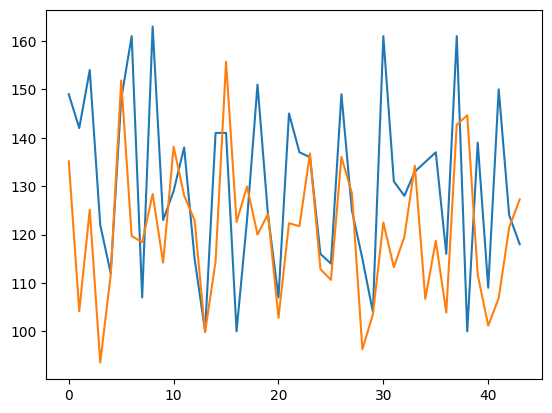

In [35]:
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

In [36]:
def plot_evaluation(y_test, y_pred):
    plt.figure()
    plt.scatter(list(range(len(y_test))), y_test, alpha = 0.5)
    plt.scatter(list(range(len(y_pred))), y_pred, alpha = 0.5)
    plt.show()
    
    plt.figure()
    plt.bar(list(range(len(y_test))), np.abs(y_test - y_pred))
    plt.show()

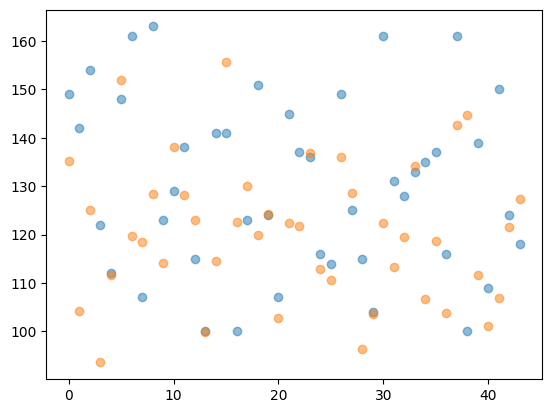

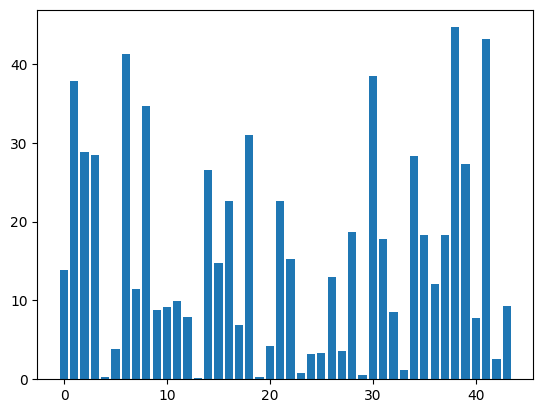

In [37]:
plot_evaluation(y_test, y_pred.flatten())

In [38]:
np.corrcoef(y_test.reshape(-1), y_pred.reshape(-1))

array([[1.        , 0.38173257],
       [0.38173257, 1.        ]])

In [39]:
def stat(y_test, y_pred, mmhg):
    return np.sum(np.abs(y_test - y_pred.flatten()) <= mmhg) / len(y_test)

print(stat(y_test, y_pred, 5))
print(stat(y_test, y_pred, 10))
print(stat(y_test, y_pred, 15))

0.2727272727272727
0.45454545454545453
0.5681818181818182
